In [ ]:
def cgi_decode(s: str) -> str:
    """Decode the CGI-encoded string `s`:
    * replace '+' by ' '
    * replace "%xx" by the character with hex number xx.
    Return the decoded string.  Raise `ValueError` for invalid inputs."""

    # Mapping of hex digits to their integer values
    hex_values = {
        "0": 0,
        "1": 1,
        "2": 2,
        "3": 3,
        "4": 4,
        "5": 5,
        "6": 6,
        "7": 7,
        "8": 8,
        "9": 9,
        "a": 10,
        "b": 11,
        "c": 12,
        "d": 13,
        "e": 14,
        "f": 15,
        "A": 10,
        "B": 11,
        "C": 12,
        "D": 13,
        "E": 14,
        "F": 15,
    }

    t = ""
    i = 0
    while i < len(s):
        c = s[i]
        if c == "+":
            t += " "
        elif c == "%":
            digit_high, digit_low = s[i + 1], s[i + 2]
            i += 2
            if digit_high in hex_values and digit_low in hex_values:
                v = hex_values[digit_high] * 16 + hex_values[digit_low]
                t += chr(v)
            else:
                raise ValueError("Invalid encoding")
        else:
            t += c
        i += 1
    return t

In [2]:
cgi_decode("Hello+World")

'Hello World'

In [3]:
assert cgi_decode("+") == " "
assert cgi_decode("%20") == " "
assert cgi_decode("abc") == "abc"

try:
    cgi_decode("%?a")
    assert False
except ValueError:
    pass

In [4]:
from types import FrameType, TracebackType
from typing import Any, Optional, Callable

coverage = []


def traceit(frame: FrameType, event: str, arg: Any) -> Optional[Callable]:
    if event == "line":
        global coverage
        function_name = frame.f_code.co_name
        lineno = frame.f_lineno
        coverage.append(lineno)

    return traceit

In [5]:
import sys


def cgi_decode_traced(s: str) -> None:
    global coverage
    coverage = []
    sys.settrace(traceit)
    cgi_decode(s)
    sys.settrace(None)

In [6]:
cgi_decode_traced("a+b")
print(coverage)

[8, 9, 8, 9, 8, 9, 8, 9, 8, 9, 8, 10, 8, 10, 8, 10, 8, 10, 8, 10, 8, 11, 8, 11, 8, 11, 8, 11, 8, 11, 8, 11, 8, 12, 8, 12, 8, 15, 16, 17, 18, 19, 21, 30, 31, 17, 18, 19, 20, 31, 17, 18, 19, 21, 30, 31, 17, 32]


In [7]:
import inspect

cgi_decode_code = inspect.getsource(cgi_decode)

In [8]:
from fuzzingbook.bookutils import print_content, print_file

print_content(cgi_decode_code[:300] + "...", ".py")

def cgi_decode(s: str) -> str:
    """Decode the CGI-encoded string `s`:
       * replace '+' by ' '
       * replace "%xx" by the character with hex number xx.
       Return the decoded string.  Raise `ValueError` for invalid inputs."""

    # Mapping of hex digits to their integer values
    hex_v...

In [9]:
cgi_decode_lines = [""] + cgi_decode_code.splitlines()
cgi_decode_lines[1]

'def cgi_decode(s: str) -> str:'

In [10]:
cgi_decode_lines[9:13]

["        '0': 0, '1': 1, '2': 2, '3': 3, '4': 4,",
 "        '5': 5, '6': 6, '7': 7, '8': 8, '9': 9,",
 "        'a': 10, 'b': 11, 'c': 12, 'd': 13, 'e': 14, 'f': 15,",
 "        'A': 10, 'B': 11, 'C': 12, 'D': 13, 'E': 14, 'F': 15,"]

In [11]:
cgi_decode_lines[15]

'    t = ""'

In [12]:
covered_lines = set(coverage)
print(covered_lines)

{32, 8, 9, 10, 11, 12, 15, 16, 17, 18, 19, 20, 21, 30, 31}


In [13]:
for lineno in range(1, len(cgi_decode_lines)):
    if lineno not in covered_lines:
        print("# ", end="")
    else:
        print("  ", end="")
    print("%2d  " % lineno, end="")
    print_content(cgi_decode_lines[lineno], ".py")
    print()

#  1  def cgi_decode(s: str) -> str:
#  2      """Decode the CGI-encoded string `s`:
#  3         * replace '+' by ' '
#  4         * replace "%xx" by the character with hex number xx.
#  5         Return the decoded string.  Raise `ValueError` for invalid inputs."""
#  6  
#  7      # Mapping of hex digits to their integer values
   8      hex_values = {
   9          '0': 0, '1': 1, '2': 2, '3': 3, '4': 4,
  10          '5': 5, '6': 6, '7': 7, '8': 8, '9': 9,
  11          'a': 10, 'b': 11, 'c': 12, 'd': 13, 'e': 14, 'f': 15,
  12          'A': 10, 'B': 11, 'C': 12, 'D': 13, 'E': 14, 'F': 15,
# 13      }
# 14  
  15      t = ""
  16      i = 0
  17      while i < len(s):
  18          c = s[i]
  19          if c == '+':
  20              t += ' '
  21          elif c == '%':
# 22              digit_high, digit_low = s[i + 1], s[i + 2]
# 23              i += 2
# 24              if digit_high in hex_values and digit_low in hex_values:
# 25                  v = hex_values[digit_high] * 

In [14]:
from typing import Tuple, List, Type, Set

Location = Tuple[str, int]

In [15]:
class Coverage:
    def __init__(self) -> None:
        self._trace: List[Location] = []

    def traceit(self, frame: FrameType, event: str, arg: Any) -> Optional[Callable]:
        if self.original_trace_function is not None:
            self.original_trace_function(frame, event, arg)

        if event == "line":
            function_name = frame.f_code.co_name
            lineno = frame.f_lineno

            if function_name != "__exit__":
                self._trace.append((function_name, lineno))

        return self.traceit

    def __enter__(self) -> Any:
        self.original_trace_function = sys.gettrace()
        sys.settrace(self.traceit)
        return self

    def __exit__(
        self, exc_type: Type, exc_value: BaseException, tb: TracebackType
    ) -> Optional[bool]:
        sys.settrace(self.original_trace_function)
        return None

    def trace(self) -> List[Location]:
        return self._trace

    def coverage(self) -> Set[Location]:
        return set(self.trace())

    def function_names(self) -> Set[str]:
        return set(function_name for (function_name, line_number) in self.coverage())

    def __repr__(self) -> str:
        t = ""

        for function_name in self.function_names():
            try:
                fun = eval(function_name)
            except Exception as exc:
                t += f"Skipping {function_name}: {exc}"
                continue
        source_lines, start_line_number = inspect.getsourcelines(fun)
        for lineno in range(start_line_number, start_line_number + len(source_lines)):
            if (function_name, lineno) not in self.trace():
                t += "# "
            else:
                t += " "
            t += "%2d  " % lineno
            t += source_lines[lineno - start_line_number]

        return t

In [16]:
with Coverage() as cov:
    cgi_decode("a+b")
print(cov.coverage())

{('cgi_decode', 18), ('cgi_decode', 31), ('cgi_decode', 15), ('cgi_decode', 21), ('cgi_decode', 11), ('cgi_decode', 8), ('cgi_decode', 30), ('cgi_decode', 17), ('cgi_decode', 32), ('cgi_decode', 20), ('cgi_decode', 10), ('cgi_decode', 16), ('cgi_decode', 19), ('cgi_decode', 9), ('cgi_decode', 12)}


In [17]:
print(cov)

#  1  def cgi_decode(s: str) -> str:
#  2      """Decode the CGI-encoded string `s`:
#  3         * replace '+' by ' '
#  4         * replace "%xx" by the character with hex number xx.
#  5         Return the decoded string.  Raise `ValueError` for invalid inputs."""
#  6  
#  7      # Mapping of hex digits to their integer values
  8      hex_values = {
  9          '0': 0, '1': 1, '2': 2, '3': 3, '4': 4,
 10          '5': 5, '6': 6, '7': 7, '8': 8, '9': 9,
 11          'a': 10, 'b': 11, 'c': 12, 'd': 13, 'e': 14, 'f': 15,
 12          'A': 10, 'B': 11, 'C': 12, 'D': 13, 'E': 14, 'F': 15,
# 13      }
# 14  
 15      t = ""
 16      i = 0
 17      while i < len(s):
 18          c = s[i]
 19          if c == '+':
 20              t += ' '
 21          elif c == '%':
# 22              digit_high, digit_low = s[i + 1], s[i + 2]
# 23              i += 2
# 24              if digit_high in hex_values and digit_low in hex_values:
# 25                  v = hex_values[digit_high] * 16 + hex_val

In [18]:
with Coverage() as cov_plus:
    cgi_decode("a+b")
with Coverage() as cov_standard:
    cgi_decode("abc")

cov_plus.coverage() - cov_standard.coverage()

{('cgi_decode', 20)}

In [19]:
with Coverage() as cov_max:
    cgi_decode("+")
    cgi_decode("%20")
    cgi_decode("abc")

    try:
        cgi_decode("%?a")
    except Exception:
        pass

In [20]:
cov_max.coverage() - cov_plus.coverage()

{('cgi_decode', 22),
 ('cgi_decode', 23),
 ('cgi_decode', 24),
 ('cgi_decode', 25),
 ('cgi_decode', 26),
 ('cgi_decode', 28)}

In [21]:
from fuzzingbook.Fuzzer import fuzzer

sample = fuzzer()
sample

'&'

In [22]:
with Coverage() as cov_fuzz:
    try:
        cgi_decode(sample)
    except:
        pass
cov_fuzz.coverage()

{('cgi_decode', 8),
 ('cgi_decode', 9),
 ('cgi_decode', 10),
 ('cgi_decode', 11),
 ('cgi_decode', 12),
 ('cgi_decode', 15),
 ('cgi_decode', 16),
 ('cgi_decode', 17),
 ('cgi_decode', 18),
 ('cgi_decode', 19),
 ('cgi_decode', 21),
 ('cgi_decode', 30),
 ('cgi_decode', 31),
 ('cgi_decode', 32)}

In [23]:
cov_max.coverage() - cov_fuzz.coverage()

{('cgi_decode', 20),
 ('cgi_decode', 22),
 ('cgi_decode', 23),
 ('cgi_decode', 24),
 ('cgi_decode', 25),
 ('cgi_decode', 26),
 ('cgi_decode', 28)}

In [24]:
trials = 100


def population_coverage(
    population: List[str], function: Callable
) -> Tuple[Set[Location], List[int]]:
    cumulative_coverage: List[int] = []
    all_coverage: Set[Location] = set()

    for s in population:
        with Coverage() as cov:
            try:
                function(s)
            except:
                pass
        all_coverage |= cov.coverage()
        cumulative_coverage.append(len(all_coverage))

    return all_coverage, cumulative_coverage

In [25]:
def hundred_input() -> List[str]:
    population = []
    for _ in range(trials):
        population.append(fuzzer())
    return population

In [26]:
all_coverage, cumulative_coverage = population_coverage(hundred_input(), cgi_decode)

Text(0, 0.5, 'lines covered')

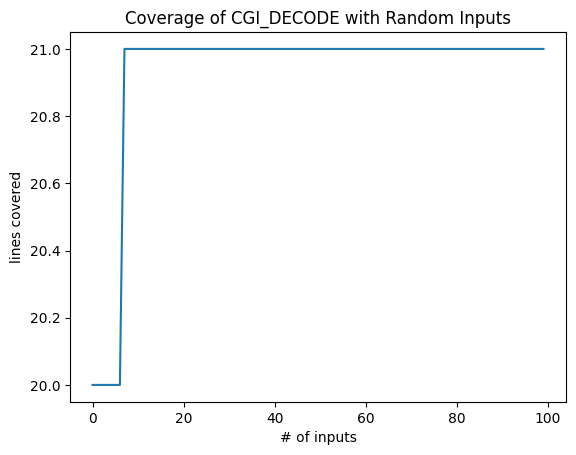

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(cumulative_coverage)
plt.title("Coverage of CGI_DECODE with Random Inputs")
plt.xlabel('# of inputs')
plt.ylabel('lines covered')

In [28]:
runs = 100
sum_coverage = [0] * trials

for run in range(runs):
    all_coverage, coverage = population_coverage(hundred_input(), cgi_decode)
    assert len(coverage) == trials
    for i in range(trials):
        sum_coverage[i] += coverage[i]
average_coverage = []
for i in range(trials):
    average_coverage.append(sum_coverage[i] / runs)

Text(0, 0.5, 'Lines covered')

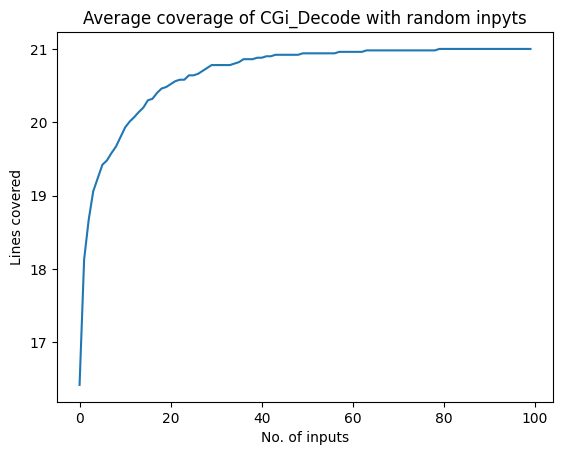

In [29]:
plt.plot(average_coverage)
plt.title("Average coverage of CGi_Decode with random inpyts")
plt.xlabel("No. of inputs")
plt.ylabel("Lines covered")

In [30]:
cgi_c_code = """
/* CGI decoding as C program */

#include <stdlib.h>
#include <string.h>
#include <stdio.h>

"""

cgi_c_code += r"""
int hex_values[256];

void init_hex_values() {
    for (int i = 0; i < sizeof(hex_values) / sizeof(int); i++) {
        hex_values[i] = -1;
    }
    hex_values['0'] = 0; hex_values['1'] = 1; hex_values['2'] = 2; hex_values['3'] = 3;
    hex_values['4'] = 4; hex_values['5'] = 5; hex_values['6'] = 6; hex_values['7'] = 7;
    hex_values['8'] = 8; hex_values['9'] = 9;

    hex_values['a'] = 10; hex_values['b'] = 11; hex_values['c'] = 12; hex_values['d'] = 13;
    hex_values['e'] = 14; hex_values['f'] = 15;

    hex_values['A'] = 10; hex_values['B'] = 11; hex_values['C'] = 12; hex_values['D'] = 13;
    hex_values['E'] = 14; hex_values['F'] = 15;
}
"""

cgi_c_code += r"""
int cgi_decode(char *s, char *t) {
    while (*s != '\0') {
        if (*s == '+')
            *t++ = ' ';
        else if (*s == '%') {
            int digit_high = *++s;
            int digit_low = *++s;
            if (hex_values[digit_high] >= 0 && hex_values[digit_low] >= 0) {
                *t++ = hex_values[digit_high] * 16 + hex_values[digit_low];
            }
            else
                return -1;
        }
        else
            *t++ = *s;
        s++;
    }
    *t = '\0';
    return 0;
}
"""


cgi_c_code += r"""
int main(int argc, char *argv[]) {
    init_hex_values();

    if (argc >= 2) {
        char *s = argv[1];
        char *t = malloc(strlen(s) + 1); /* output is at most as long as input */
        int ret = cgi_decode(s, t);
        printf("%s\n", t);
        return ret;
    }
    else
    {
        printf("cgi_decode: usage: cgi_decode STRING\n");
        return 1;
    }
}
"""

In [31]:
with open("cgi_decode.c", "w") as f:
    f.write(cgi_c_code)

In [32]:
from fuzzingbook.bookutils import print_file

print_file("cgi_decode.c")

/* CGI decoding as C program */

#include <stdlib.h>
#include <string.h>
#include <stdio.h>


int hex_values[256];

void init_hex_values() {
    for (int i = 0; i < sizeof(hex_values) / sizeof(int); i++) {
        hex_values[i] = -1;
    }
    hex_values['0'] = 0; hex_values['1'] = 1; hex_values['2'] = 2; hex_values['3'] = 3;
    hex_values['4'] = 4; hex_values['5'] = 5; hex_values['6'] = 6; hex_values['7'] = 7;
    hex_values['8'] = 8; hex_values['9'] = 9;

    hex_values['a'] = 10; hex_values['b'] = 11; hex_values['c'] = 12; hex_values['d'] = 13;
    hex_values['e'] = 14; hex_values['f'] = 15;

    hex_values['A'] = 10; hex_values['B'] = 11; hex_values['C'] = 12; hex_values['D'] = 13;
    hex_values['E'] = 14; hex_values['F'] = 15;
}

int cgi_decode(char *s, char *t) {
    while (*s != '\0') {
        if (*s == '+')
            *t++ = ' ';
        else if (*s == '%') {
            int digit_high = *++s;
            int digit_low = *++s;
            if (hex_values[digit_high] >= 0 && 

In [33]:
!gcc --coverage -o cgi_decode cgi_decode.c

In [34]:
!./cgi_decode 'Send+mail+to+me%40fuzzingbook.org'

Send mail to me@fuzzingbook.org


In [35]:
!gcov cgi_decode cgi_decode-cgi_decode

cgi_decode-cgi_decode.gcno:cannot open notes file
cgi_decode-cgi_decode.gcda:cannot open data file, assuming not executed
File 'cgi_decode.c'
Lines executed:91.43% of 35
Creating 'cgi_decode.c.gcov'

Lines executed:91.43% of 35


In [36]:
def read_gcov_coverage(c_file):
    gcov_file = c_file + ".gcov"
    coverage = set()
    with open(gcov_file) as file:
        for line in file.readlines():
            elems = line.split(":")
            covered = elems[0].strip()
            line_number = int(elems[1].strip())
            if covered.startswith("-") or covered.startswith("#"):
                continue
            coverage.add((c_file, line_number))

        return coverage

In [37]:
coverage = read_gcov_coverage("cgi_decode.c")
list(coverage)[:5]

[('cgi_decode.c', 55),
 ('cgi_decode.c', 12),
 ('cgi_decode.c', 15),
 ('cgi_decode.c', 27),
 ('cgi_decode.c', 24)]

In [38]:
from fuzzingbook.ExpectError import ExpectError

with ExpectError():
    for _ in range(trials):
        try:
            s = fuzzer()
            cgi_decode(s)
        except ValueError:
            pass

In [39]:
s

'&$<)8$6*!230,=3\'8\'0\'(:4&")1%.)+:?!-'

In [40]:
import os, glob

for file in (
    glob.glob("cgi_decode") + glob.glob("cgi_decode.*") + glob.glob("cgi_decode-*")
):
    os.remove(file)

***Exercise 1: Fixing cgi_decode()***

In [ ]:
def fixed_cgi_decode(s):
    """Decode the CGI-encoded string `s`:
    * replace "+" by " "
    * replace "%xx" by the character with hex number xx.
    Return the decoded string.  Raise `ValueError` for invalid inputs."""

    # Mapping of hex digits to their integer values
    hex_values = {
        "0": 0,
        "1": 1,
        "2": 2,
        "3": 3,
        "4": 4,
        "5": 5,
        "6": 6,
        "7": 7,
        "8": 8,
        "9": 9,
        "a": 10,
        "b": 11,
        "c": 12,
        "d": 13,
        "e": 14,
        "f": 15,
        "A": 10,
        "B": 11,
        "C": 12,
        "D": 13,
        "E": 14,
        "F": 15,
    }

    t = ""
    i = 0
    while i < len(s):
        c = s[i]
        if c == "+":
            t += " "
        elif c == "%" and i + 2 < len(s):  # <--- *** FIX ***
            digit_high, digit_low = s[i + 1], s[i + 2]
            i += 2
            if digit_high in hex_values and digit_low in hex_values:
                v = hex_values[digit_high] * 16 + hex_values[digit_low]
                t += chr(v)
            else:
                raise ValueError("Invalid encoding")
        else:
            t += c
        i += 1
    return t

In [42]:
with ExpectError():
    for _ in range(trials):
        try:
            s = fuzzer()
            cgi_decode(s)
        except ValueError:
            pass

Traceback (most recent call last):
  File "/tmp/ipykernel_31584/113896642.py", line 5, in <module>
    cgi_decode(s)
  File "/tmp/ipykernel_31584/1071239422.py", line 22, in cgi_decode
    digit_high, digit_low = s[i + 1], s[i + 2]
                            ~^^^^^^^
IndexError: string index out of range (expected)


In [43]:
assert fixed_cgi_decode("%") == "%"
assert fixed_cgi_decode("%4") == "%4"
assert fixed_cgi_decode("%40") == "@"

In [ ]:
cgi_c_code = cgi_c_code.replace(
    r"if (*s == '%')",  # old code
    r"if (*s == '%' && s[1] != '\0' && s[2] != '\0')",  # new code
)

In [45]:
with Coverage() as cov:
    cgi_decode("a+b")
trace = cov.trace()
trace[:5]

[('cgi_decode', 8),
 ('cgi_decode', 9),
 ('cgi_decode', 8),
 ('cgi_decode', 9),
 ('cgi_decode', 8)]

In [ ]:
def branch_coverage(trace):
    coverate = set()
    past_line = None
    for line in trace:
        if past_line is not None:
            coverage.add((past_line, line))
        past_line = line
    return coverage

In [47]:
branch_coverage(trace)

{('cgi_decode.c', 11),
 ('cgi_decode.c', 12),
 ('cgi_decode.c', 13),
 ('cgi_decode.c', 15),
 ('cgi_decode.c', 16),
 ('cgi_decode.c', 17),
 ('cgi_decode.c', 19),
 ('cgi_decode.c', 20),
 ('cgi_decode.c', 22),
 ('cgi_decode.c', 23),
 ('cgi_decode.c', 24),
 ('cgi_decode.c', 26),
 ('cgi_decode.c', 27),
 ('cgi_decode.c', 28),
 ('cgi_decode.c', 29),
 ('cgi_decode.c', 30),
 ('cgi_decode.c', 31),
 ('cgi_decode.c', 32),
 ('cgi_decode.c', 33),
 ('cgi_decode.c', 34),
 ('cgi_decode.c', 40),
 ('cgi_decode.c', 41),
 ('cgi_decode.c', 43),
 ('cgi_decode.c', 44),
 ('cgi_decode.c', 47),
 ('cgi_decode.c', 48),
 ('cgi_decode.c', 50),
 ('cgi_decode.c', 51),
 ('cgi_decode.c', 52),
 ('cgi_decode.c', 53),
 ('cgi_decode.c', 54),
 ('cgi_decode.c', 55),
 (('cgi_decode', 10), ('cgi_decode', 8)),
 (('cgi_decode', 11), ('cgi_decode', 8)),
 (('cgi_decode', 12), ('cgi_decode', 8)),
 (('cgi_decode', 15), ('cgi_decode', 16)),
 (('cgi_decode', 16), ('cgi_decode', 17)),
 (('cgi_decode', 17), ('cgi_decode', 18)),
 (('cgi_d

In [ ]:
class BranchCoverage(Coverage):
    def coverage(self):
        coverage = set()
        past_line = None
        for line in self.trace():
            if past_line is not None:
                coverage.add((past_line, line))
            past_line = line

        return coverage

In [49]:
with BranchCoverage() as cov:
    cgi_decode("a+b")
print(cov.coverage())

{(('cgi_decode', 18), ('cgi_decode', 19)), (('cgi_decode', 21), ('cgi_decode', 30)), (('cgi_decode', 10), ('cgi_decode', 8)), (('cgi_decode', 16), ('cgi_decode', 17)), (('cgi_decode', 19), ('cgi_decode', 20)), (('cgi_decode', 8), ('cgi_decode', 9)), (('cgi_decode', 19), ('cgi_decode', 21)), (('cgi_decode', 8), ('cgi_decode', 15)), (('cgi_decode', 30), ('cgi_decode', 31)), (('cgi_decode', 8), ('cgi_decode', 10)), (('cgi_decode', 17), ('cgi_decode', 32)), (('cgi_decode', 8), ('cgi_decode', 11)), (('cgi_decode', 31), ('cgi_decode', 17)), (('cgi_decode', 11), ('cgi_decode', 8)), (('cgi_decode', 8), ('cgi_decode', 12)), (('cgi_decode', 15), ('cgi_decode', 16)), (('cgi_decode', 20), ('cgi_decode', 31)), (('cgi_decode', 12), ('cgi_decode', 8)), (('cgi_decode', 17), ('cgi_decode', 18)), (('cgi_decode', 9), ('cgi_decode', 8))}


In [50]:
with BranchCoverage() as cov_plus:
    cgi_decode("a+b")
with BranchCoverage() as cov_standard:
    cgi_decode("abc")

cov_plus.coverage() - cov_standard.coverage()

{(('cgi_decode', 19), ('cgi_decode', 20)),
 (('cgi_decode', 20), ('cgi_decode', 31))}

In [ ]:
with BranchCoverage() as cov_max:
    cgi_decode("+")
    cgi_decode("%20")
    cgi_decode("abc")
    try:
        cgi_decode("%?a")
    except:
        pass

In [52]:
cov_max.coverage() - cov_plus.coverage()

{(('cgi_decode', 21), ('cgi_decode', 22)),
 (('cgi_decode', 22), ('cgi_decode', 23)),
 (('cgi_decode', 23), ('cgi_decode', 24)),
 (('cgi_decode', 24), ('cgi_decode', 25)),
 (('cgi_decode', 24), ('cgi_decode', 28)),
 (('cgi_decode', 25), ('cgi_decode', 26)),
 (('cgi_decode', 26), ('cgi_decode', 31)),
 (('cgi_decode', 32), ('cgi_decode', 8))}

In [53]:
sample

'&'

In [54]:
with BranchCoverage() as cov_fuzz:
    try:
        cgi_decode(s)
    except:
        pass
cov_fuzz.coverage()

{(('cgi_decode', 8), ('cgi_decode', 9)),
 (('cgi_decode', 8), ('cgi_decode', 10)),
 (('cgi_decode', 8), ('cgi_decode', 11)),
 (('cgi_decode', 8), ('cgi_decode', 12)),
 (('cgi_decode', 8), ('cgi_decode', 15)),
 (('cgi_decode', 9), ('cgi_decode', 8)),
 (('cgi_decode', 10), ('cgi_decode', 8)),
 (('cgi_decode', 11), ('cgi_decode', 8)),
 (('cgi_decode', 12), ('cgi_decode', 8)),
 (('cgi_decode', 15), ('cgi_decode', 16)),
 (('cgi_decode', 16), ('cgi_decode', 17)),
 (('cgi_decode', 17), ('cgi_decode', 18)),
 (('cgi_decode', 18), ('cgi_decode', 19)),
 (('cgi_decode', 19), ('cgi_decode', 21)),
 (('cgi_decode', 21), ('cgi_decode', 22)),
 (('cgi_decode', 21), ('cgi_decode', 30)),
 (('cgi_decode', 30), ('cgi_decode', 31)),
 (('cgi_decode', 31), ('cgi_decode', 17))}

In [55]:
cov_max.coverage() - cov_fuzz.coverage()

{(('cgi_decode', 17), ('cgi_decode', 32)),
 (('cgi_decode', 19), ('cgi_decode', 20)),
 (('cgi_decode', 20), ('cgi_decode', 31)),
 (('cgi_decode', 22), ('cgi_decode', 23)),
 (('cgi_decode', 23), ('cgi_decode', 24)),
 (('cgi_decode', 24), ('cgi_decode', 25)),
 (('cgi_decode', 24), ('cgi_decode', 28)),
 (('cgi_decode', 25), ('cgi_decode', 26)),
 (('cgi_decode', 26), ('cgi_decode', 31)),
 (('cgi_decode', 32), ('cgi_decode', 8))}

In [56]:
def population_branch_coverage(population, function):
    cumulative_coverage = []
    all_coverage = set()

    for s in population:
        with BranchCoverage() as cov:
            try:
                function(s)
            except Exception:
                pass
        all_coverage |= cov.coverage()
        cumulative_coverage.append(len(all_coverage))

    return all_coverage, cumulative_coverage

In [ ]:
all_branch_coverage, cumulative_branch_coverage = population_branch_coverage(
    hundred_input(), cgi_decode
)

Text(0, 0.5, 'line pairs covered')

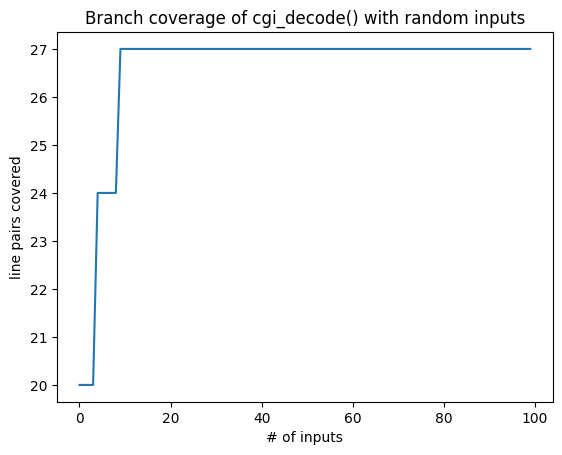

In [ ]:
plt.plot(cumulative_branch_coverage)
plt.title("Branch coverage of cgi_decode() with random inputs")
plt.xlabel("# of inputs")
plt.ylabel("line pairs covered")

In [59]:
len(cov_max.coverage())

28

In [60]:
all_branch_coverage - cov_max.coverage()

set()

In [61]:
cov_max.coverage() - all_branch_coverage

{(('cgi_decode', 32), ('cgi_decode', 8))}

In [ ]:
runs = 100

# Create an array with TRIALS elements, all zero
sum_coverage = [0] * trials

for run in range(runs):
    all_branch_coverage, coverage = population_branch_coverage(
        hundred_input(), cgi_decode
    )
    assert len(coverage) == trials
    for i in range(trials):
        sum_coverage[i] += coverage[i]

average_coverage = []
for i in range(trials):
    average_coverage.append(sum_coverage[i] / runs)

Text(0, 0.5, 'line pairs covered')

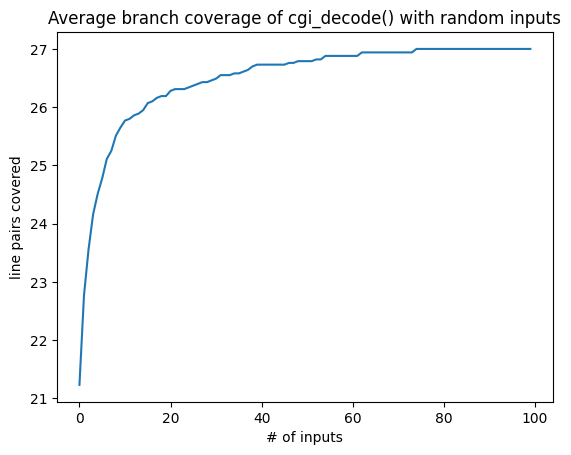

In [ ]:
plt.plot(average_coverage)
plt.title("Average branch coverage of cgi_decode() with random inputs")
plt.xlabel("# of inputs")
plt.ylabel("line pairs covered")